In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

In [3]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
from moe_em_model import moe_em_model
from moe_expectation_model import moe_expectation_model
from moe_concat_model import moe_concat_model
from moe_pre_softmax_expectation_model import moe_pre_softmax_expectation_model
from moe_stochastic_model import moe_stochastic_model, moe_stochastic_loss
from moe_models import cross_entropy_loss

device cpu
device cpu
device cpu
device cpu
device cpu
device cpu


In [6]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [7]:
dataset = 'mnist'

In [8]:
fig_path = '/Users/peac004/modular_learning_research/papers/neurips_xai_workshop_2021/figures'
model_path = '/Users/peac004/modular_learning_research/papers/neurips_xai_workshop_2021/results/'

In [9]:
trainsize = 10048
testsize = 2000

In [10]:
# datasets
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

bs = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0,trainsize)), 
                                          batch_size=bs,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=2000,
                                         shuffle=False)


# imade size and number of images
image, label = trainset.__getitem__(0)
print(image.shape, len(trainset))

torch.Size([1, 28, 28]) 60000


In [11]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Labels: tensor([9, 2, 1, 4, 7, 1, 2, 3, 7, 3, 9, 0, 6, 9, 0, 1, 5, 9, 2, 3, 4, 7, 8, 9,
        8, 2, 2, 0, 7, 2, 2, 5, 3, 7, 1, 3, 7, 6, 3, 3, 1, 1, 2, 5, 2, 1, 9, 8,
        7, 4, 9, 4, 1, 7, 8, 9, 2, 0, 6, 2, 0, 5, 5, 2])


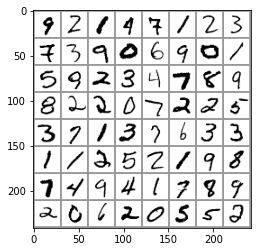

In [12]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('Labels:', labels)
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid, one_channel=True)


In [13]:
class expert_layers(nn.Module):
    def __init__(self, masks, num_classes, output, fill='rand', fill_w=None, fill_b=None):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.masks = masks
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        if not self.masks is None:
            mask = torch.zeros(t.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = t[:,i] 
            return mask
        
        return t

In [14]:
class expert_layers_presoftmax(nn.Module):
    def __init__(self, masks, num_classes, output, fill='rand', fill_w=None, fill_b=None):
        super(expert_layers_presoftmax, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.masks = masks
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        #print('CONV T SHAPE', t.shape)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        
        if not self.masks is None:
            mask = torch.zeros(t.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = t[:,i] 
            return mask
               
        return t

In [15]:
#Expert network
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes, fill='rand', fill_w=None, fill_b=None):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        if not y is None:
            t = torch.cat((t, torch.flatten(y, start_dim=1)), dim=1)
            self.fc1 = nn.Linear(in_features=1*12*12+(self.num_experts* self.num_classes), out_features=15)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [16]:
# create a set of experts
def experts(num_experts, masks, total_num_classes, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(masks[i], total_num_classes, num_classes[i], 
                                         fill=fill, fill_w=expert_weights_init[i], fill_b=expert_bias_init[i]))
    return nn.ModuleList(models)

In [17]:
# compute
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [18]:
total_experts = 5

In [19]:
num_classes = 10

In [20]:
num_epochs = 20

In [21]:
fill = 'rand'

In [22]:
expert_weights_init = [None]*total_experts
expert_bias_init = [None]*total_experts
gate_weights_init = None
gate_bias_init = None

In [23]:
# experiment with models with different number of experts
w_importance=0.0
w_ortho = 0.0
w_ideal_gate = 0.0

augment = False
attention = False
T_max = 1
#T_decay = T_max/num_epochs
#T_decay = T_max/(num_epochs - T_decay_start)
T_decay = 0
T_decay_start = 0

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if T_decay > 0:
        plot_file += '_Tdecay_'+str(T_decay)
    if T_decay_start > 0:
        plot_file += '_Tdecaystart_'+str(T_decay_start)
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    if augment:
        plot_file += '_augment'
    if attention:
        plot_file += '_attention'
    plot_file += '_'+specific
    
    return plot_file


In [24]:
def train(trainloader, testloader, model, optimizer, loss_criterion, epochs, pre_softmax=False):
    first = True
    for epoch in range(epochs):
        running_accuracy = 0.0
        num_batches = 0
        test_accuracy = 0.0
        for inputs, labels in trainloader:
            
            if first:
                # create grid of images
                img_grid = torchvision.utils.make_grid(inputs)

                # show images
                imshow(img_grid, one_channel=True)
                first = False

            optimizer.zero_grad()
            outputs = model(inputs)
            if pre_softmax:
                outputs = F.softmax(outputs, dim=1)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_accuracy += accuracy(outputs, labels)
            num_batches+=1
            
        test_batches = 0
        for inputs, labels in testloader:
            test_outputs = model(inputs)
                
            if pre_softmax:
                test_outputs = F.softmax(test_outputs, dim=1)
            test_accuracy += accuracy(test_outputs, labels)
            test_batches += 1
            
        with torch.no_grad():
            running_accuracy = running_accuracy.cpu().numpy()/num_batches
            test_accuracy = test_accuracy.cpu().numpy()/test_batches
            print('epoch %d' % epoch,
                  ' train accuracy %.2f' % running_accuracy, 
                  'val accuracy %.2f' % test_accuracy)

In [25]:
classes_per_expert = [[0,1], [2,5], [3,4], [6,9],[7,8]]
class_expert_map = {0:0,1:0,2:1,5:1,3:2,4:2,6:3,9:3,7:4,8:4}

In [26]:
classes_per_expert_str = ''
for labels in classes_per_expert:
    buffer = "_".join(str(labels).replace('[','').replace(']','').replace(',','_').replace(" ",'')).replace('_','')
    classes_per_expert_str += buffer+'_'
classes_per_expert_str = classes_per_expert_str.strip('_')
classes_per_expert_str

'01_25_34_69_78'

In [27]:
def train_experts(total_experts, total_num_classes, num_classes, trainset, testset, pre_softmax=False):
    batchsize = bs
    if pre_softmax:
        expert_models = experts(total_experts,
                                classes_per_expert, total_num_classes, 
                                num_classes, expert_layers_presoftmax)
    else:
        expert_models = experts(total_experts, 
                                classes_per_expert, total_num_classes, 
                                num_classes)

    for classes, exp_i in zip(classes_per_expert, range(0,total_experts)):
                    
        index_0_1 = torch.tensor([],dtype=torch.long)
        for label in classes:
            index_0_1 = torch.cat([torch.where(trainset.targets[range(0,trainsize)]==label)[0], index_0_1])

        print('train labels', np.unique(trainset.targets[range(0,trainsize)][index_0_1]))
        trainloader_0_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(trainset, range(0,trainsize)),index_0_1), 
                                                      batch_size=batchsize,
                                                      shuffle=True, num_workers=1, pin_memory=True)
        
        index_0_1 = torch.tensor([],dtype=torch.long)
        for label in classes:
            index_0_1 = torch.cat([torch.where(testset.targets[range(0,testsize)]==label)[0], index_0_1])
        
        print('test labels', np.unique(testset.targets[range(0,testsize)][index_0_1]))
        testloader_0_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(testset, range(0,testsize)),index_0_1), 
                                                    batch_size=testsize,
                                                    shuffle=True, num_workers=1, pin_memory=True)

        optimizer_expert = optim.RMSprop(expert_models[exp_i].parameters(), lr=0.01, momentum=0.9)

        
        train(trainloader_0_1, testloader_0_1, expert_models[exp_i], optimizer_expert, cross_entropy_loss(), 20, pre_softmax)
    for i in range(0,total_experts):
        for param in expert_models[i].parameters():
            param.requires_grad = False
    return expert_models

train labels [0 1]
test labels [0 1]
epoch 0  train accuracy 0.92 val accuracy 0.99
epoch 1  train accuracy 0.99 val accuracy 0.99
epoch 2  train accuracy 0.99 val accuracy 0.99
epoch 3  train accuracy 0.99 val accuracy 0.99
epoch 4  train accuracy 0.99 val accuracy 0.99
epoch 5  train accuracy 0.99 val accuracy 0.99
epoch 6  train accuracy 0.99 val accuracy 0.99
epoch 7  train accuracy 0.99 val accuracy 0.99
epoch 8  train accuracy 0.99 val accuracy 0.99
epoch 9  train accuracy 0.99 val accuracy 0.99
epoch 10  train accuracy 0.99 val accuracy 0.99
epoch 11  train accuracy 0.99 val accuracy 0.99
epoch 12  train accuracy 0.99 val accuracy 0.99
epoch 13  train accuracy 0.99 val accuracy 0.99
epoch 14  train accuracy 0.99 val accuracy 0.99
epoch 15  train accuracy 0.99 val accuracy 0.99
epoch 16  train accuracy 0.99 val accuracy 0.99
epoch 17  train accuracy 0.99 val accuracy 0.99
epoch 18  train accuracy 0.99 val accuracy 0.99
epoch 19  train accuracy 0.99 val accuracy 0.99
train labels 

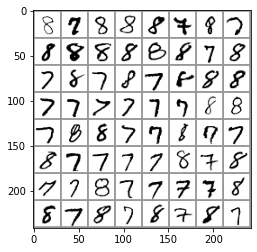

In [47]:
expert_models = train_experts(total_experts, num_classes, [2,2,2,2,2], trainset, testset)

In [28]:
plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str+'_expert_model.pt')

In [49]:
torch.save(expert_models,open(os.path.join(model_path, plot_file),'wb'))

In [29]:
expert_models = torch.load(os.path.join(model_path, plot_file))

In [34]:
expert_presoftmax_models = train_experts(total_experts, num_classes, [2,2,2], x_train, y_train, x_test, y_test, True)

train labels [0 1]
test labels [0 1]
epoch 0  train accuracy 0.87 val accuracy 1.00
epoch 1  train accuracy 1.00 val accuracy 1.00
epoch 2  train accuracy 1.00 val accuracy 1.00
epoch 3  train accuracy 1.00 val accuracy 1.00
epoch 4  train accuracy 1.00 val accuracy 1.00
epoch 5  train accuracy 1.00 val accuracy 1.00
epoch 6  train accuracy 1.00 val accuracy 1.00
epoch 7  train accuracy 1.00 val accuracy 1.00
epoch 8  train accuracy 1.00 val accuracy 1.00
epoch 9  train accuracy 1.00 val accuracy 1.00
epoch 10  train accuracy 1.00 val accuracy 1.00
epoch 11  train accuracy 1.00 val accuracy 1.00
epoch 12  train accuracy 1.00 val accuracy 1.00
epoch 13  train accuracy 1.00 val accuracy 1.00
epoch 14  train accuracy 1.00 val accuracy 1.00
epoch 15  train accuracy 1.00 val accuracy 1.00
epoch 16  train accuracy 1.00 val accuracy 1.00
epoch 17  train accuracy 1.00 val accuracy 1.00
epoch 18  train accuracy 1.00 val accuracy 1.00
epoch 19  train accuracy 1.00 val accuracy 1.00
train labels 

In [35]:
plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str+'_expert_presoftmax_model.pt')

In [36]:
torch.save(expert_presoftmax_models,open(os.path.join(model_path, plot_file),'wb'))

In [37]:
expert_presoftmax_models = torch.load(os.path.join(model_path, plot_file))

In [30]:
dataset_1 = 'mnist_pretrained'

In [31]:
for T in range(1, T_max+1):
    print('Temperature', T)
    models = {
            'moe_em_model':{'model':moe_em_model,'loss':cross_entropy_loss,'experts':{}},
            'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss(cross_entropy_loss),'experts':{}}
         }

    for key, val in models.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                exp_models = expert_presoftmax_models
            else:
                exp_models = expert_models
            gate_model = gate_layers( num_experts, num_classes, fill,
                                    fill_w=gate_weights_init, fill_b=gate_bias_init)
            moe_model = val['model'](num_experts, num_classes, augment, attention, exp_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.001, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.001, momentum=0.9)

            hist = moe_model.train(trainloader, testloader, val['loss'], 
                                   optimizer_moe, optimizer_gate, optimizer_experts,
                                   w_importance, w_ortho,
                                   T=T, accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_1, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    
        

Temperature 1
Model: moe_em_model
Number of experts  5
model params: 27167
step 0 training loss 2.62 , training accuracy 0.21 , test accuracy 0.22


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-552db7ab675b>", line 32, in <module>
    hist = moe_model.train(trainloader, testloader, val['loss'],
  File "/Users/peac004/modular_learning_research/modular_deep_learning/pytorch/moe_em_model.py", line 215, in train
    for test_inputs, test_labels in new_batch:
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 363, in __next__
    data = self._next_data()
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 974, in _next_data
    idx, data = self._get_data()
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 941, in _get_data


TypeError: object of type 'NoneType' has no len()

In [54]:
for T in range(T_max, T_max+1):
    print('Temperature', T)
    models = {
#             'moe_em_model':{'model':moe_em_model,'loss':cross_entropy_loss,'experts':{}},
#             'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
#             'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss(cross_entropy_loss),'experts':{}}
            }
    for key, val in models.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, 
                                        [num_classes]*num_experts, expert_layers_presoftmax)
            else:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
            gate_model = gate_layers(num_experts, num_classes)
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.001, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.001, momentum=0.9)
            hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                                   optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
            plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
            torch.save(models,open(os.path.join(model_path, plot_file),'wb'))
                

Temperature 1
Model: moe_expectation_model
Number of experts  5


TypeError: super(type, obj): obj must be an instance or subtype of type

In [76]:
plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))

In [19]:
def predict(dataloader, model):
    pred_labels = []
    true_labels = []
    for i, data in enumerate(dataloader):
        inputs, labels = data
        true_labels.append(labels)
        pred_labels.append(torch.argmax(model(inputs), dim=1))

    return torch.stack(true_labels), torch.stack(pred_labels)

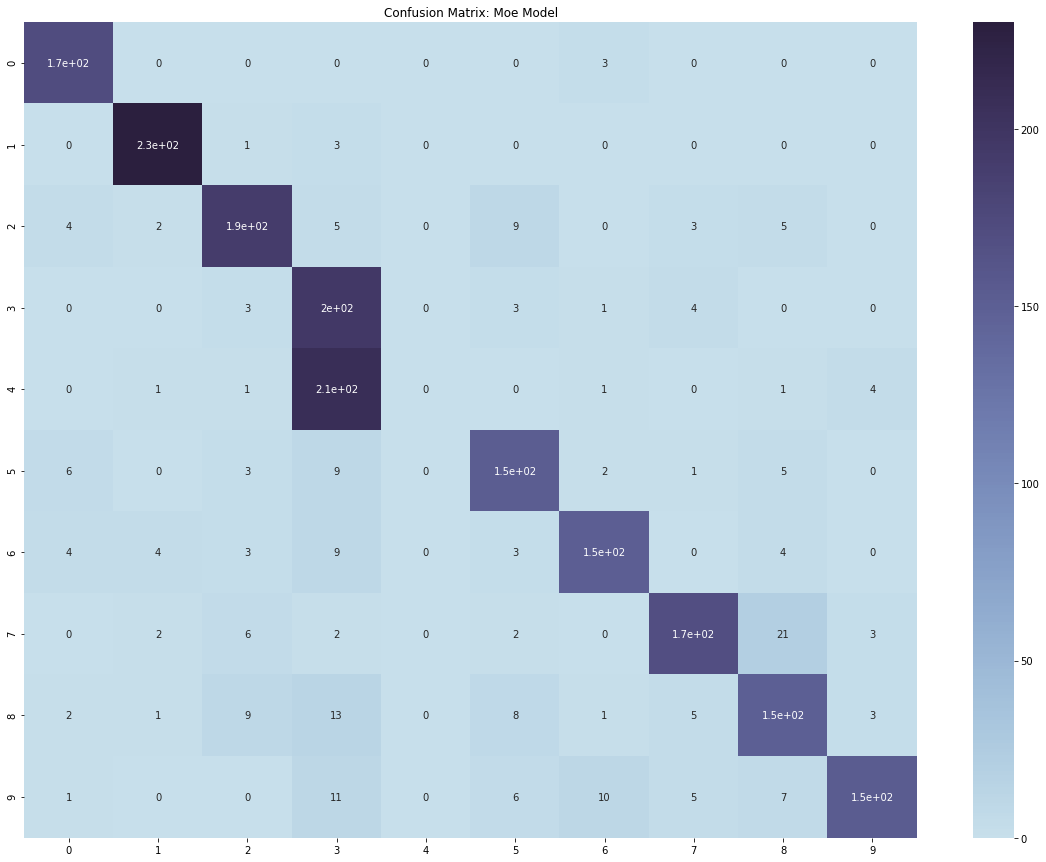

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for e_key, e_val in models.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
    
    fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20,15))
#     fig,ax = plt.subplots(total_experts, 1, sharex=False, sharey=False, figsize=(20,15*(total_experts+1)))

    for images, labels in testloader:
        with torch.no_grad():
            moe_model = e_val['experts'][total_experts]['model']

            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs

            sns.heatmap(confusion_matrix(labels, pred_labels), annot=True, ax=ax1, cmap=cmap)
            ax1.set_title('Confusion Matrix: Moe Model')

#             for i in range(total_experts):
#                 pred_labels = torch.argmax(expert_outputs[:,i,:], dim=1)
#                 if total_experts > 1:
#                     sns.heatmap(confusion_matrix(labels, pred_labels), annot=True, ax=ax[i+1], cmap=cmap)
#                     ax[i+1].set_title('Confusion Matrix: Expert '+str(i)+' Model')
        plt.show()

In [53]:
palette = [plt.get_cmap('tab20')(i) for i in range(20)]
palette.pop(6)
palette.pop(6)

(1.0, 0.596078431372549, 0.5882352941176471, 1.0)

In [54]:
def colors(p,  palette=['y','g','r','c','b','tab:pink','tab:brown','tab:cyan','tab:olive','tab:purple']):
    uniq_y = np.unique(p)
    pred_color = [palette[i] for i in uniq_y]
    return pred_color

In [55]:
def pca_tsne_plot(X, y, classes, dataset, size, filter_class=False):
    transformer = IncrementalPCA(n_components=50, batch_size=128)
    if filter_class:
        index = filter_classes(classes_sub, size)
    else:
        index = list(range(0,size))
    X_pca = transformer.fit_transform(X.reshape(X.shape[0],X.shape[-1]*X.shape[-1]))
    X_pca = X_pca[index]
    print('X:',X.shape)
    y = y[index]
    print(np.unique(y, return_counts=True))
    print('PCA:',X_pca.shape)
    print('y:', y.shape)
    X_embedded = TSNE(n_components=2,perplexity=50.0,).fit_transform(X_pca)
    print('TSNE:',X_embedded.shape)    
    fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))
    true_label_names = [classes[i] for i in y]
    true_color = colors(y, palette[0:len(classes)]) 
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=true_label_names, hue_order=classes, palette=true_color, ax=ax)
    plt.savefig('figures/fashion_mnist/'+dataset+'.png')
    return X_pca, X_embedded
    

In [56]:
classes = list(range(num_classes))
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

X: torch.Size([2000, 1, 28, 28])
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([175, 234, 219, 207, 217, 179, 178, 205, 192, 194]))
PCA: (2000, 50)
y: torch.Size([2000])
TSNE: (2000, 2)


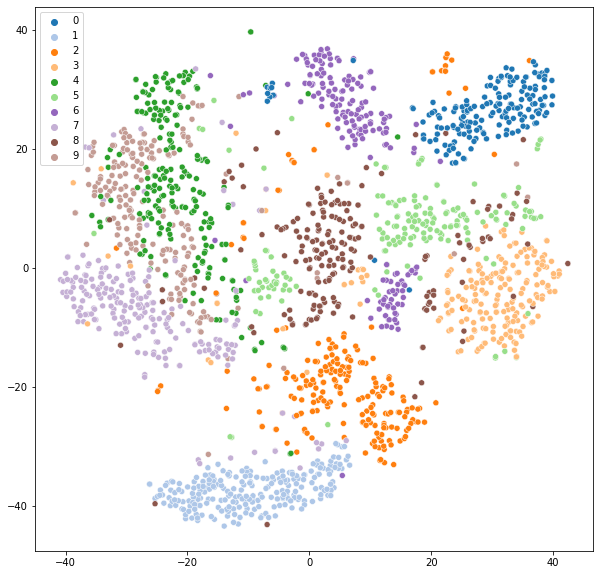

In [57]:
size = 2000
for X, y in testloader:
    X_pca, X_tsne = pca_tsne_plot(X, y, classes, dataset, size)

In [58]:
def get_labels(p):
    pred_labels = torch.argmax(p, dim=1)
    return pred_labels

Number of Experts: 5
Temperature 1
torch.Size([2000, 5, 10])


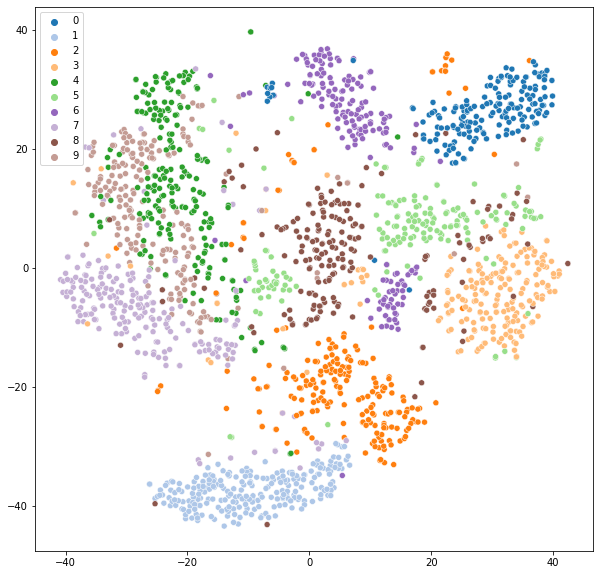

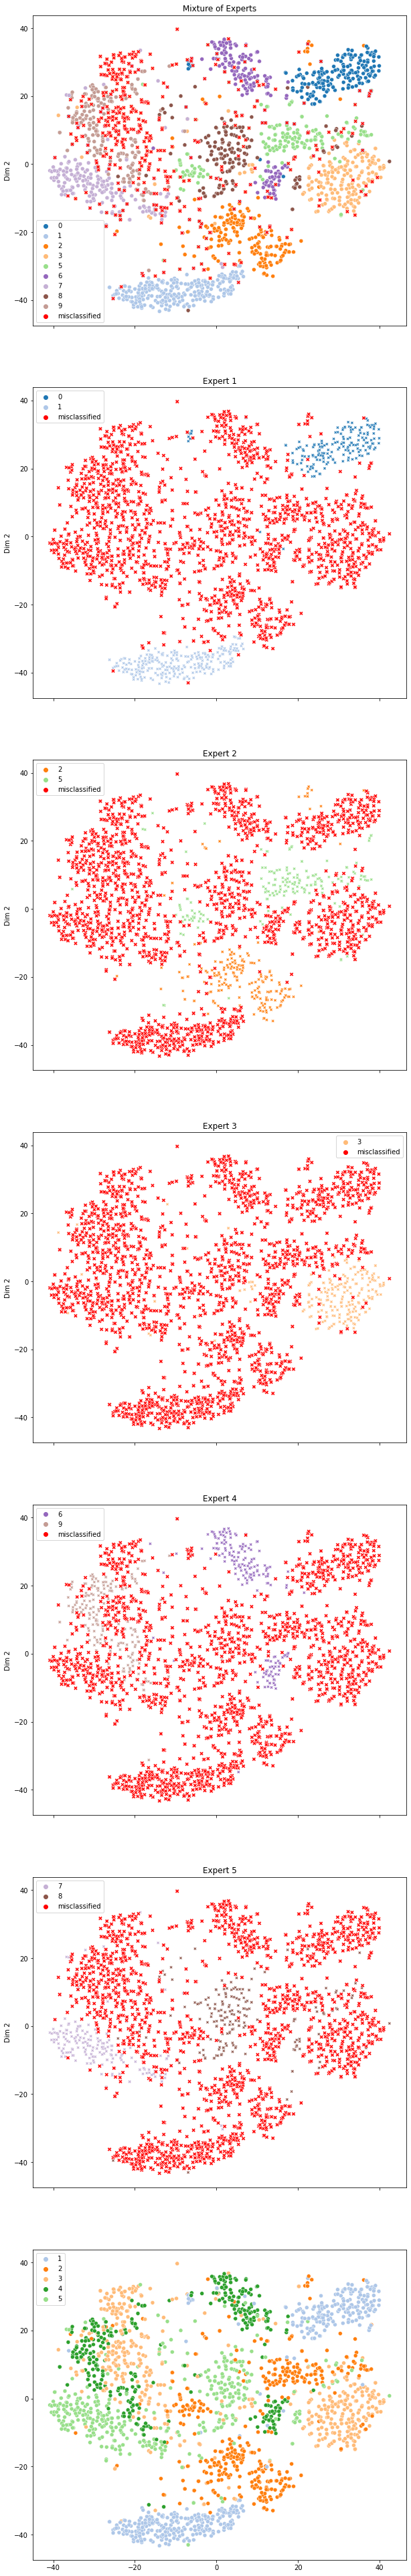

In [59]:
for T in range(1, T_max+1):

    plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    models = torch.load(os.path.join(model_path, plot_file))

    keys = models.keys()
    N = len(keys)

    fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,10))

    for X, y in testloader:
        true_label_names = [classes[i] for i in y]
        true_color = colors(y, palette[0:num_classes]) 
        sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1], 
                        hue=true_label_names, hue_order=classes, palette=true_color,ax=ax)

    for e in range(total_experts, total_experts+1):
        nrows = 2+e
        ncols = N
        thefigsize = (ncols*10,nrows*10)

        print('Number of Experts:', e)
        print('Temperature', str(T))

        fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
        ax = ax.flatten()


        index = 0
        for X, y in testloader:
            for m_key, m_val in models.items():

                moe_model = m_val['experts'][e]['model']

                pred = moe_model(X)
                pred_labels = get_labels(pred)
                pred_label_names = [classes[i] for i in pred_labels]
                pred_color = colors(pred_labels, palette[0:num_classes])
                pred_classes = [classes[i] for i in np.unique(pred_labels)]

                true_label_names = [classes[i] for i in y]
                true_color = colors(y, palette[0:num_classes]) 

                sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                                hue=pred_label_names,hue_order=pred_classes,palette=pred_color, ax=ax[index])
                indices = np.where((pred_labels == y) == False)[0]
                sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                                hue=['misclassified']*len(indices), palette=['r'], marker='X', ax=ax[index])

                ax[index].set_title('Mixture of Experts')
                ax[index].set_ylabel('Dim 2')
                ax[index].set_xlabel('Dim 1')


                print(moe_model.expert_outputs.shape)
                for i in range(e):
                    pred_expert_labels = get_labels(moe_model.expert_outputs[:,i,:])

                    indices = np.where((pred_expert_labels == y) == True)[0]

                    pred_expert_label_names = [classes[i] for i in pred_expert_labels[indices]]
                    pred_expert_color = colors(pred_expert_labels[indices], palette[0:num_classes])
                    pred_expert_classes = [classes[i] for i in np.unique(pred_expert_labels[indices])]
                    sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                                hue=pred_expert_label_names,hue_order=pred_expert_classes,palette=pred_expert_color,marker='X', s=20,alpha=1.0, ax=ax[N*(i+1)+index])
                    indices = np.where((pred_expert_labels == y) == False)[0]
                    sns.scatterplot(x=X_tsne[indices,0],y=X_tsne[indices,1],
                                hue=['misclassified']*len(indices), palette=['r'], marker='X', ax=ax[N*(i+1)+index])

                    ax[N*(i+1)+index].set_title('Expert '+str(i+1))
                    ax[N*(i+1)+index].set_ylabel('Dim 2')
                    ax[N*(i+1)+index].set_xlabel('Dim 1')

                pred_gate = moe_model.gate_outputs
                pred_gate_labels = get_labels(pred_gate)+1
                pred_gate_color = colors(pred_gate_labels, palette)

                sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],
                                hue=pred_gate_labels,hue_order=np.unique(pred_gate_labels),palette=pred_gate_color, ax=ax[N*(e+1)+index])       

                index += 1
        image_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes))
        filename = os.path.join('figures/review', image_file+'_'+str(e)+'_experts.png')
        plt.savefig(filename)
        plt.show()
    


In [49]:
prediction_errors = (predicted_classes != y_test)

tensor([False, False, False])

In [45]:
torch.sum( prediction_errors)

tensor(1766)

In [46]:
error_images = x_test[ prediction_errors.type(torch.bool)]
error_images.shape

torch.Size([1766, 1, 28, 28])

In [50]:
error_labels = predicted_classes[ prediction_errors.type(torch.bool)]
error_labels.shape

torch.Size([1766])

tensor([4, 3, 7, 1, 9, 1, 7, 9, 4, 3, 3, 4, 2, 5, 3, 5, 5, 1, 3, 1, 4, 3, 3, 3,
        3, 1, 5, 1, 1, 2, 9, 5])


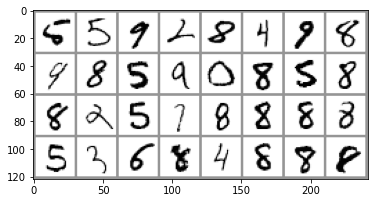

In [51]:
# create grid of images
img_grid = torchvision.utils.make_grid(error_images[0:32])
imshow( img_grid, True)
print(error_labels[0:32])

Are these numbers badly drawn?  Are there plausible reasons why they have been misclassified? What are some different reasons?  (There are several different types of reason - this is typical of real problems with large datasets.) 

*Self help*: Modify the `plot_images` statement above to give the images titles with the true classification and the (wrong) predicted classification.